In [1]:
%matplotlib inline

## Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=3)
from wordcloud import WordCloud, STOPWORDS
import pickle
import re


INFO: Pandarallel will run on 18 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
PROJECT_DIR = '/vol/aimspace/projects/practical_WS2425/vision_language'

DATA_DIR = os.path.join(PROJECT_DIR, 'data/interims')

with open(f'{DATA_DIR}/nlmcxr_preprocessed.pkl', 'rb') as f:
    nlmcxr_df = pickle.load(f)

In [3]:
nlmcxr_df.head() 

,file_path,image_file_path_resized,comparison_tokenized,indication_tokenized,findings_tokenized,impression_tokenized,image_caption_tokenized
0,/vol/aimspace/projects/practical_WS2425/vision...,/vol/aimspace/projects/practical_WS2425/vision...,[],"[Positive, TB, test]","[The, cardiac, silhouette, and, mediastinum, s...","[Normal, chest, x-, XXXX, .]","[Xray, Chest, PA, and, Lateral]"
1,/vol/aimspace/projects/practical_WS2425/vision...,/vol/aimspace/projects/practical_WS2425/vision...,[],"[Positive, TB, test]","[The, cardiac, silhouette, and, mediastinum, s...","[Normal, chest, x-, XXXX, .]","[Xray, Chest, PA, and, Lateral]"
2,/vol/aimspace/projects/practical_WS2425/vision...,/vol/aimspace/projects/practical_WS2425/vision...,"[Chest, radiographs, XXXX, .]","[XXXX, -, year, -, old, male, ,, chest, pain, .]","[The, cardiomediastinal, silhouette, is, withi...","[No, acute, cardiopulmonary, process, .]","[PA, and, lateral, chest, x, -, XXXX, XXXX, .]"
3,/vol/aimspace/projects/practical_WS2425/vision...,/vol/aimspace/projects/practical_WS2425/vision...,"[Chest, radiographs, XXXX, .]","[XXXX, -, year, -, old, male, ,, chest, pain, .]","[The, cardiomediastinal, silhouette, is, withi...","[No, acute, cardiopulmonary, process, .]","[PA, and, lateral, chest, x, -, XXXX, XXXX, .]"
4,/vol/aimspace/projects/practical_WS2425/vision...,/vol/aimspace/projects/practical_WS2425/vision...,[],[],"[Both, lungs, are, clear, and, expanded, ., He...","[No, active, disease, .]","[CHEST, 2V, FRONTAL, /, LATERAL, XXXX, ,, XXXX..."


In [4]:
nlmcxr_df.info()
nlmcxr_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7430 entries, 0 to 7429
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   file_path                7430 non-null   object
 1   image_file_path_resized  7430 non-null   object
 2   comparison_tokenized     7430 non-null   object
 3   indication_tokenized     7430 non-null   object
 4   findings_tokenized       7430 non-null   object
 5   impression_tokenized     7430 non-null   object
 6   image_caption_tokenized  7430 non-null   object
dtypes: object(7)
memory usage: 406.5+ KB


,file_path,image_file_path_resized,comparison_tokenized,indication_tokenized,findings_tokenized,impression_tokenized,image_caption_tokenized
count,7430,7430,7430,7430,7430,7430,7430
unique,3826,7430,393,2453,2553,1770,625
top,/vol/aimspace/projects/practical_WS2425/vision...,/vol/aimspace/projects/practical_WS2425/vision...,[],"[Chest, pain]",[],"[No, acute, cardiopulmonary, abnormality, .]","[Xray, Chest, PA, and, Lateral]"
freq,5,1,2709,253,957,586,2360


In [5]:
nlmcxr_df.shape

(7430, 7)

### Checking for empty sentences


In [6]:
def has_empty_sentence(tokenized_text):
    return len(tokenized_text) == 0

In [7]:
nlmcxr_df[nlmcxr_df['comparison_tokenized'].apply(has_empty_sentence)]
nlmcxr_df[nlmcxr_df['indication_tokenized'].apply(has_empty_sentence)]
nlmcxr_df[nlmcxr_df['findings_tokenized'].apply(has_empty_sentence)]
nlmcxr_df[nlmcxr_df['impression_tokenized'].apply(has_empty_sentence)]
nlmcxr_df[nlmcxr_df['image_caption_tokenized'].apply(has_empty_sentence)]


print(f"Entries with empty comparison sentences: {nlmcxr_df[nlmcxr_df['comparison_tokenized'].apply(has_empty_sentence)].shape[0]}")
print(f"Entries with empty indication sentences: {nlmcxr_df[nlmcxr_df['indication_tokenized'].apply(has_empty_sentence)].shape[0]}")
print(f"Entries with empty findings sentences: {nlmcxr_df[nlmcxr_df['findings_tokenized'].apply(has_empty_sentence)].shape[0]}")
print(f"Entries with empty impression sentences: {nlmcxr_df[nlmcxr_df['impression_tokenized'].apply(has_empty_sentence)].shape[0]}")
print(f"Entries with empty image caption sentences: {nlmcxr_df[nlmcxr_df['image_caption_tokenized'].apply(has_empty_sentence)].shape[0]}")

Entries with empty comparison sentences: 2709
Entries with empty indication sentences: 119
Entries with empty findings sentences: 957
Entries with empty impression sentences: 12
Entries with empty image caption sentences: 2


In [8]:
#empty report sentences are the ones without all comparison, indication, findings, impression
empty_report_sentences = nlmcxr_df[nlmcxr_df['comparison_tokenized'].apply(has_empty_sentence) & nlmcxr_df['indication_tokenized'].apply(has_empty_sentence) & nlmcxr_df['findings_tokenized'].apply(has_empty_sentence) & nlmcxr_df['impression_tokenized'].apply(has_empty_sentence)]
print(f"Entries with all empty report sentences: {empty_report_sentences.shape[0]}")

Entries with all empty report sentences: 0


### Grouping by file_path

In [9]:
# Group the DataFrame by file_path
grouped = nlmcxr_df.groupby('file_path')

# Initialize a list to store the new rows
new_rows = []

# Check for duplicates in the specified columns and aggregate accordingly
for name, group in grouped:
    # Convert lists to tuples for uniqueness check
    comparison_unique = group['comparison_tokenized'].apply(tuple).nunique()
    indication_unique = group['indication_tokenized'].apply(tuple).nunique()
    findings_unique = group['findings_tokenized'].apply(tuple).nunique()
    impression_unique = group['impression_tokenized'].apply(tuple).nunique()
    
    # Check if all columns have duplicates
    if (comparison_unique == 1 and indication_unique == 1 and 
        findings_unique == 1 and impression_unique == 1):
        # Take the first occurrence if all are duplicates
        new_row = {
            'file_path': name,
            'comparison_tokenized': group['comparison_tokenized'].iloc[0],
            'indication_tokenized': group['indication_tokenized'].iloc[0],
            'findings_tokenized': group['findings_tokenized'].iloc[0],
            'impression_tokenized': group['impression_tokenized'].iloc[0],
            'image_caption_tokenized': group['image_caption_tokenized'].iloc[0],
            'image_file_path_resized': group['image_file_path_resized'].tolist()
        }
    else:
        # Take all unique values if there are any unique ones
        new_row = {
            'file_path': name,
            'comparison_tokenized': list(set(tuple(x) for x in group['comparison_tokenized'])),
            'indication_tokenized': list(set(tuple(x) for x in group['indication_tokenized'])),
            'findings_tokenized': list(set(tuple(x) for x in group['findings_tokenized'])),
            'impression_tokenized': list(set(tuple(x) for x in group['impression_tokenized'])),
            'image_caption_tokenized': list(set(tuple(x) for x in group['image_caption_tokenized'])),
            'image_file_path_resized': group['image_file_path_resized'].tolist()
        }
    
    new_rows.append(new_row)

# Create a new DataFrame from the aggregated rows
nlmcxr_df_grouped = pd.DataFrame(new_rows)

In [10]:
nlmcxr_df_grouped.head()

,file_path,comparison_tokenized,indication_tokenized,findings_tokenized,impression_tokenized,image_caption_tokenized,image_file_path_resized
0,/vol/aimspace/projects/practical_WS2425/vision...,[],"[Positive, TB, test]","[The, cardiac, silhouette, and, mediastinum, s...","[Normal, chest, x-, XXXX, .]","[Xray, Chest, PA, and, Lateral]",[/vol/aimspace/projects/practical_WS2425/visio...
1,/vol/aimspace/projects/practical_WS2425/vision...,"[Chest, radiographs, XXXX, .]","[XXXX, -, year, -, old, male, ,, chest, pain, .]","[The, cardiomediastinal, silhouette, is, withi...","[No, acute, cardiopulmonary, process, .]","[PA, and, lateral, chest, x, -, XXXX, XXXX, .]",[/vol/aimspace/projects/practical_WS2425/visio...
2,/vol/aimspace/projects/practical_WS2425/vision...,[],[],"[Both, lungs, are, clear, and, expanded, ., He...","[No, active, disease, .]","[CHEST, 2V, FRONTAL, /, LATERAL, XXXX, ,, XXXX...",[/vol/aimspace/projects/practical_WS2425/visio...
3,/vol/aimspace/projects/practical_WS2425/vision...,"[XXXX, PA, and, lateral, chest, radiographs]","[XXXX, -, year, -, old, male, ,, XXXX, .]","[There, is, XXXX, increased, opacity, within, ...","[1., Increased, opacity, in, the, right, upper...","[PA, and, lateral, chest, x, -, XXXX, XXXX, .]",[/vol/aimspace/projects/practical_WS2425/visio...
4,/vol/aimspace/projects/practical_WS2425/vision...,[None],"[dyspnea, ,, subjective, fevers, ,, arthritis,...","[Interstitial, markings, are, diffusely, promi...","[Diffuse, fibrosis, ., No, visible, focal, acu...","[CHEST, 2V, FRONTAL, /, LATERAL, XXXX, ,, XXXX...",[/vol/aimspace/projects/practical_WS2425/visio...


In [11]:
nlmcxr_df_grouped.info()
nlmcxr_df_grouped.describe()
nlmcxr_df_grouped.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3826 entries, 0 to 3825
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   file_path                3826 non-null   object
 1   comparison_tokenized     3826 non-null   object
 2   indication_tokenized     3826 non-null   object
 3   findings_tokenized       3826 non-null   object
 4   impression_tokenized     3826 non-null   object
 5   image_caption_tokenized  3826 non-null   object
 6   image_file_path_resized  3826 non-null   object
dtypes: object(7)
memory usage: 209.4+ KB


(3826, 7)

### Plotting number of images per report frequency

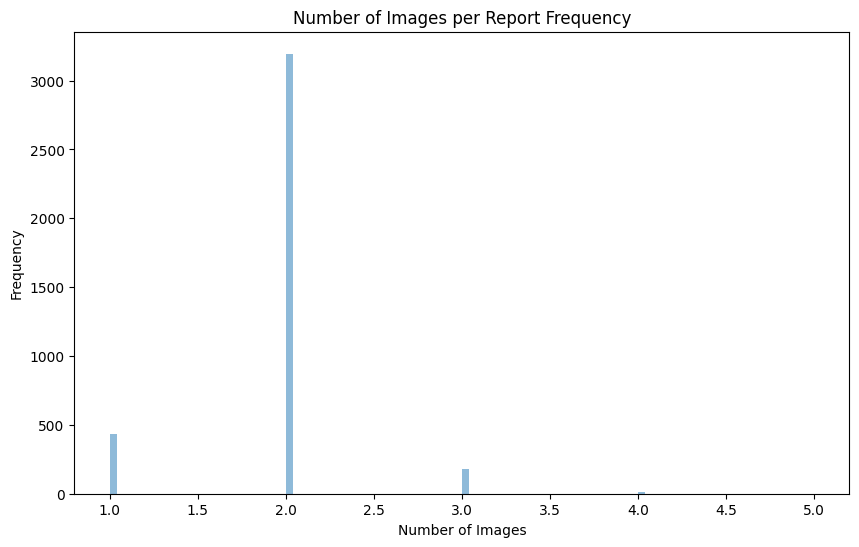

In [12]:
#plot number of images per report frequency
plt.figure(figsize=(10, 6))
plt.hist(nlmcxr_df_grouped['image_file_path_resized'].apply(len), bins=100, alpha=0.5, label='Number of Images per Report')
plt.title('Number of Images per Report Frequency')
plt.xlabel('Number of Images')
plt.ylabel('Frequency')
plt.show()

In [13]:
def clean_tokenized_array(tokenized_array):
    """Remove unwanted elements from tokenized arrays using regex and wordcloud Stopwords"""
    stopwords = set(STOPWORDS)
    cleaned_array = [
        token for token in tokenized_array 
        if not re.match(r'^(XXXX|XXXX\.|x|\.|[-,\.]|[0-9]+\.)$', token)   # Regex to match 'XXXX' 'XXXX.', 'x', '-', ',', or '.' or digits followed by period 
        and token not in stopwords
    ]
    return cleaned_array

In [14]:
nlmcxr_df_grouped['comparison_tokenized'] = nlmcxr_df_grouped['comparison_tokenized'].apply(clean_tokenized_array)
nlmcxr_df_grouped['indication_tokenized'] = nlmcxr_df_grouped['indication_tokenized'].apply(clean_tokenized_array)
nlmcxr_df_grouped['findings_tokenized'] = nlmcxr_df_grouped['findings_tokenized'].apply(clean_tokenized_array)
nlmcxr_df_grouped['impression_tokenized'] = nlmcxr_df_grouped['impression_tokenized'].apply(clean_tokenized_array)
nlmcxr_df_grouped['image_caption_tokenized'] = nlmcxr_df_grouped['image_caption_tokenized'].apply(clean_tokenized_array)

### Convert all tokens to lowercase
This is to avoid having duplicate tokens due to case sensitivity.

In [15]:
def tokens_to_lowercase(tokenized_array):
    """Convert all tokens in the tokenized array to lowercase."""
    return [token.lower() for token in tokenized_array]

In [16]:
nlmcxr_df_grouped['comparison_tokenized'] = nlmcxr_df_grouped['comparison_tokenized'].apply(tokens_to_lowercase)
nlmcxr_df_grouped['indication_tokenized'] = nlmcxr_df_grouped['indication_tokenized'].apply(tokens_to_lowercase)
nlmcxr_df_grouped['findings_tokenized'] = nlmcxr_df_grouped['findings_tokenized'].apply(tokens_to_lowercase)
nlmcxr_df_grouped['impression_tokenized'] = nlmcxr_df_grouped['impression_tokenized'].apply(tokens_to_lowercase)
nlmcxr_df_grouped['image_caption_tokenized'] = nlmcxr_df_grouped['image_caption_tokenized'].apply(tokens_to_lowercase)

In [17]:
nlmcxr_df_grouped.head()

,file_path,comparison_tokenized,indication_tokenized,findings_tokenized,impression_tokenized,image_caption_tokenized,image_file_path_resized
0,/vol/aimspace/projects/practical_WS2425/vision...,[],"[positive, tb, test]","[the, cardiac, silhouette, mediastinum, size, ...","[normal, chest, x-]","[xray, chest, pa, lateral]",[/vol/aimspace/projects/practical_WS2425/visio...
1,/vol/aimspace/projects/practical_WS2425/vision...,"[chest, radiographs]","[year, old, male, chest, pain]","[the, cardiomediastinal, silhouette, within, n...","[no, acute, cardiopulmonary, process]","[pa, lateral, chest]",[/vol/aimspace/projects/practical_WS2425/visio...
2,/vol/aimspace/projects/practical_WS2425/vision...,[],[],"[both, lungs, clear, expanded, heart, mediasti...","[no, active, disease]","[chest, 2v, frontal, /, lateral, pm]",[/vol/aimspace/projects/practical_WS2425/visio...
3,/vol/aimspace/projects/practical_WS2425/vision...,"[pa, lateral, chest, radiographs]","[year, old, male]","[there, increased, opacity, within, right, upp...","[increased, opacity, right, upper, lobe, assoc...","[pa, lateral, chest]",[/vol/aimspace/projects/practical_WS2425/visio...
4,/vol/aimspace/projects/practical_WS2425/vision...,[none],"[dyspnea, subjective, fevers, arthritis, immig...","[interstitial, markings, diffusely, prominent,...","[diffuse, fibrosis, no, visible, focal, acute,...","[chest, 2v, frontal, /, lateral, pm]",[/vol/aimspace/projects/practical_WS2425/visio...


### Calculate token counts & plotting token counts
Plotting the token counts for each tokenized column can provide insights into the distribution of tokens in each column and can help identify any patterns or themes.


{'Comparisons': 3715, 'Indications': 14510, 'Findings': 77909, 'Impressions': 32823, 'Image Captions': 17462}


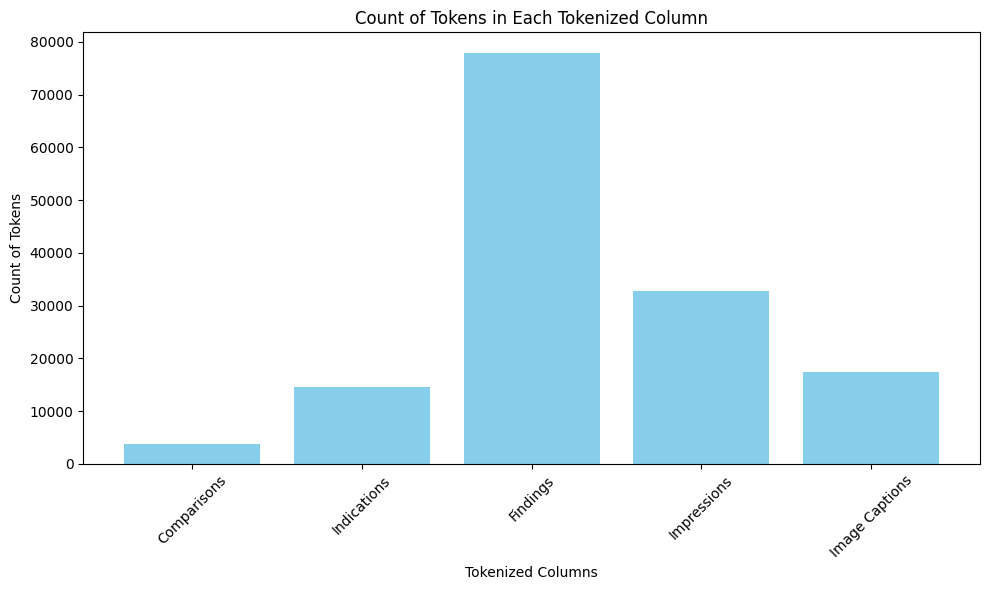

In [18]:
def plot_token_counts(df):
    """Plot the count of elements for each specified tokenized column with renamed axes."""
    # Define the mapping of original column names to new names
    column_name_mapping = {
        'comparison_tokenized': 'Comparisons',
        'indication_tokenized': 'Indications',
        'findings_tokenized': 'Findings',
        'impression_tokenized': 'Impressions',
        'image_caption_tokenized': 'Image Captions'
    }
    
    # Calculate the count of tokens for each column
    token_counts = {column_name_mapping[column]: df[column].explode().count() for column in column_name_mapping.keys()}

    print(token_counts)
    # Create a bar plot for the token counts
    plt.figure(figsize=(10, 6))
    plt.bar(token_counts.keys(), token_counts.values(), color='skyblue')
    plt.title('Count of Tokens in Each Tokenized Column')
    plt.xlabel('Tokenized Columns')
    plt.ylabel('Count of Tokens')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Call the function to plot the token counts
plot_token_counts(nlmcxr_df_grouped)

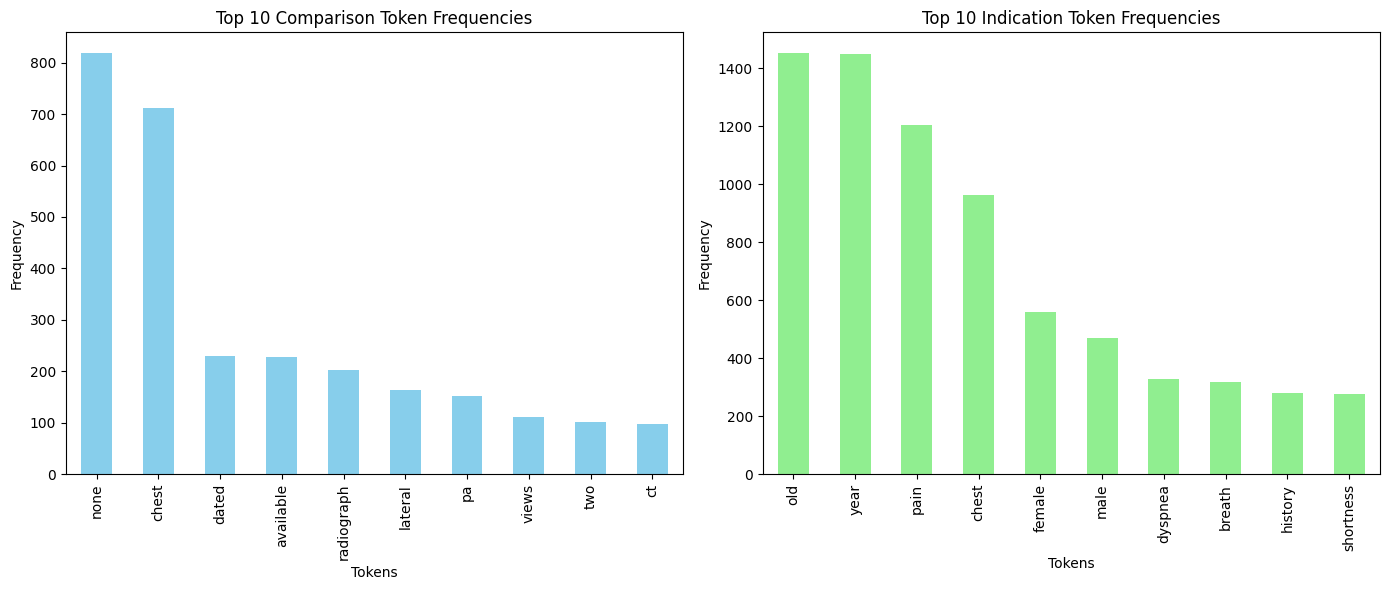

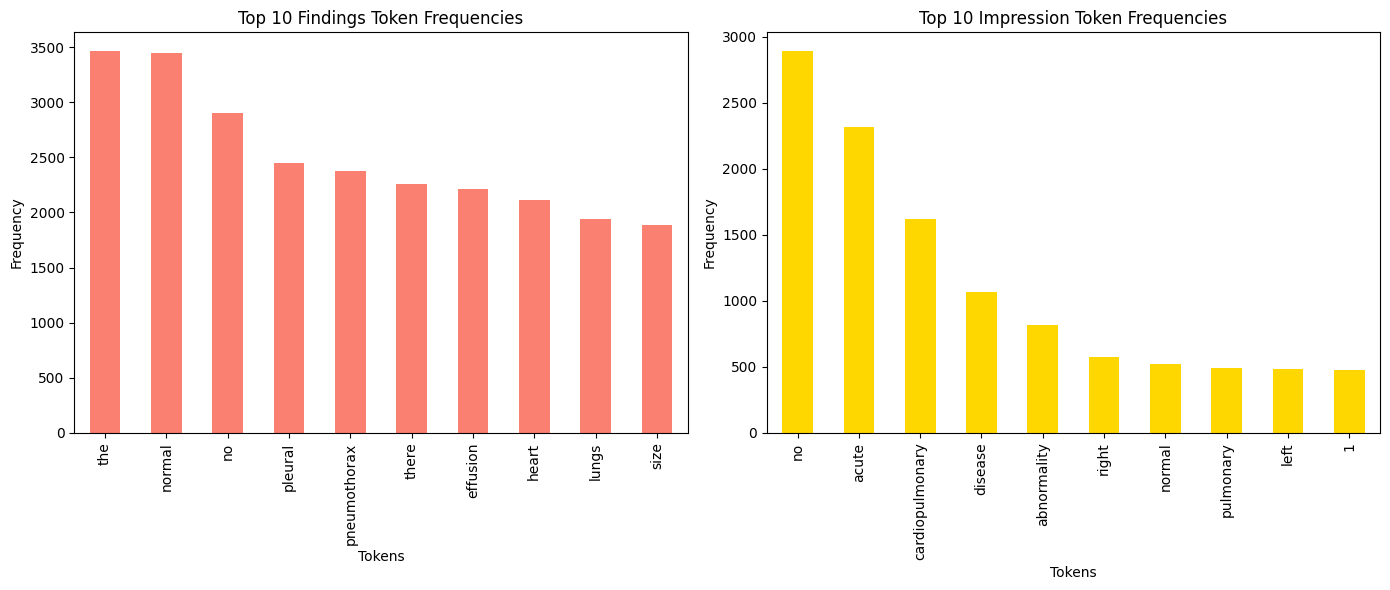

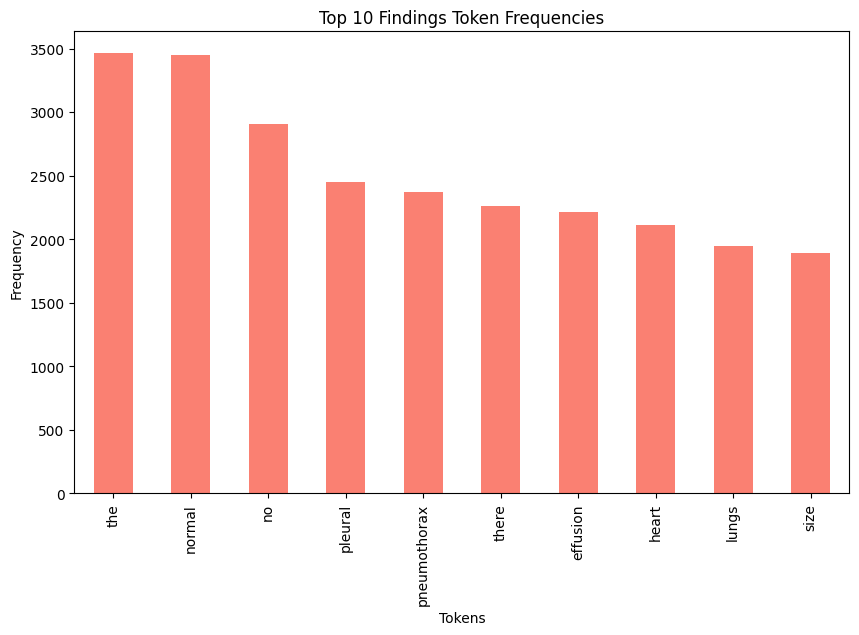

In [19]:
# Function to plot frequency distributions
def plot_frequency_distributions(df):
    # Calculate frequency distributions
    comparison_freq = df['comparison_tokenized'].explode().value_counts()
    indication_freq = df['indication_tokenized'].explode().value_counts()
    findings_freq = df['findings_tokenized'].explode().value_counts()
    impression_freq = df['impression_tokenized'].explode().value_counts()

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Comparison Frequency
    comparison_freq.head(10).plot(kind='bar', ax=axs[0], color='skyblue')
    axs[0].set_title('Top 10 Comparison Token Frequencies')
    axs[0].set_xlabel('Tokens')
    axs[0].set_ylabel('Frequency')
    
    # Plot Indication Frequency
    indication_freq.head(10).plot(kind='bar', ax=axs[1], color='lightgreen')
    axs[1].set_title('Top 10 Indication Token Frequencies')
    axs[1].set_xlabel('Tokens')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot Findings Frequency
    findings_freq.head(10).plot(kind='bar', ax=axs[0], color='salmon')
    axs[0].set_title('Top 10 Findings Token Frequencies')
    axs[0].set_xlabel('Tokens')
    axs[0].set_ylabel('Frequency')
    
    # Plot Impression Frequency
    impression_freq.head(10).plot(kind='bar', ax=axs[1], color='gold')
    axs[1].set_title('Top 10 Impression Token Frequencies')
    axs[1].set_xlabel('Tokens')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    findings_freq.head(10).plot(kind='bar', color='salmon')
    plt.title('Top 10 Findings Token Frequencies')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.show()

# Call the function to plot the frequency distributions
plot_frequency_distributions(nlmcxr_df_grouped)

### Calculate word frequencies & plotting word clouds
Identifying the most common words in the findings and impressions can provide insights into the typical content of these reports and can inform us of which words are most important in these reports.

Word clouds can help visualize the most common words in the findings and impressions as well as identify any patterns or themes.

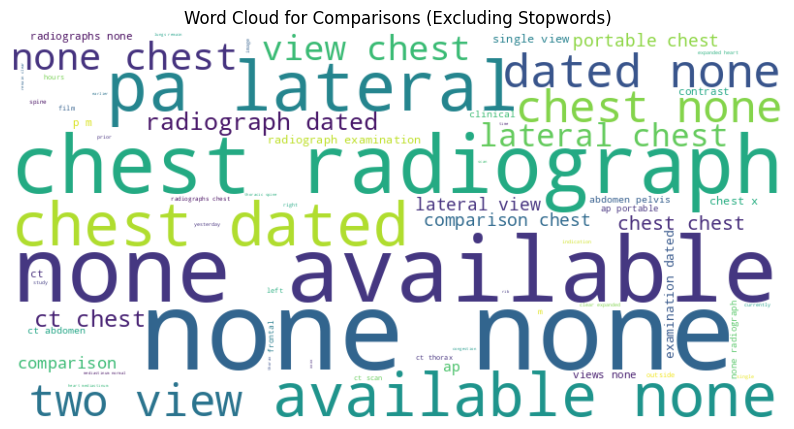

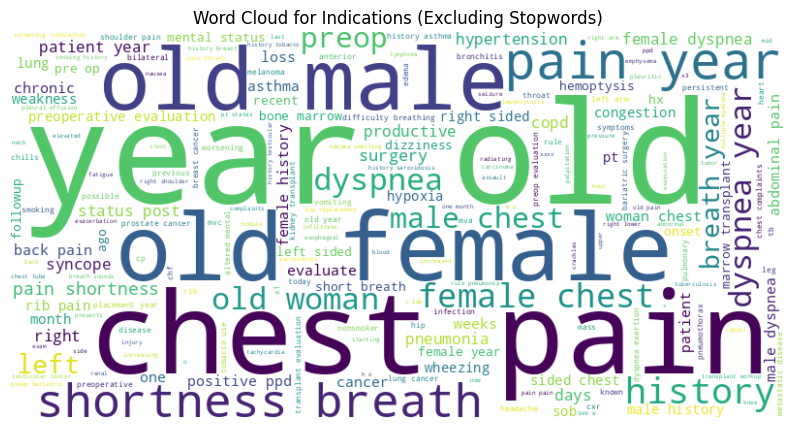

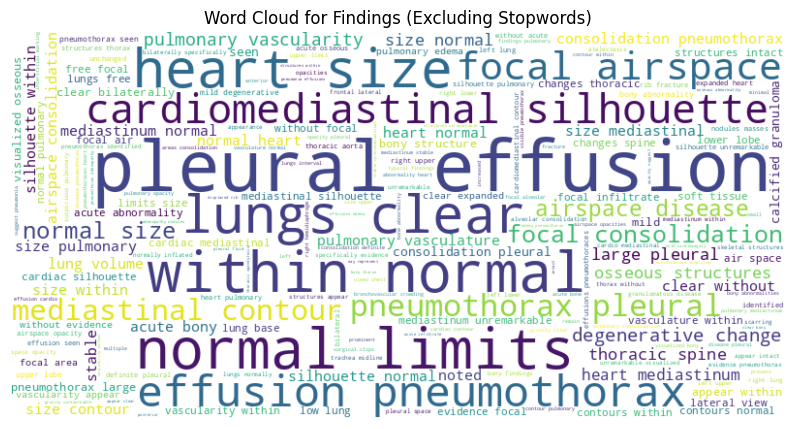

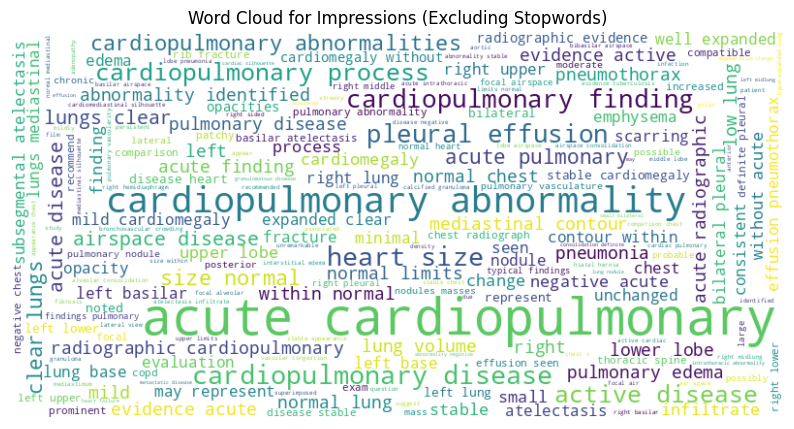

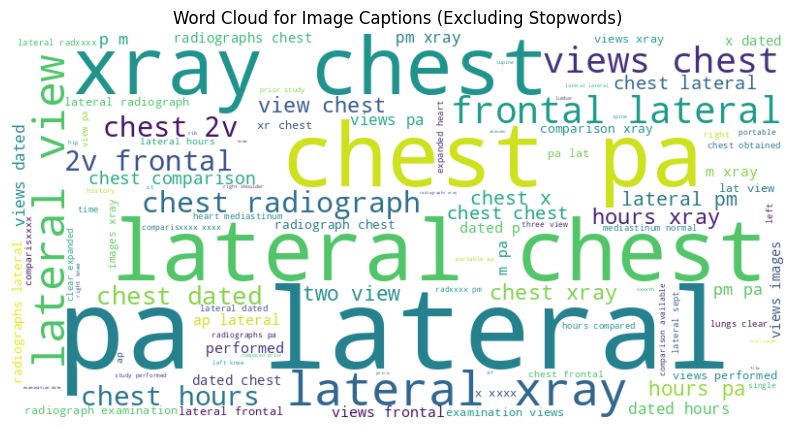

In [20]:
def plot_word_cloud(tokenized_array, column_name):
    """Generate and display a word cloud for a given tokenized array."""
    # Combine all tokens into a single string, excluding stopwords
    all_text = ' '.join(tokenized_array.explode().dropna())  # Combine all tokens into a single string
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400).generate(all_text)

    # Display the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.title(f'Word Cloud for {column_name.replace("_", " ").title()} (Excluding Stopwords)')
    plt.show()

# Call the function separately for each tokenized column
plot_word_cloud(nlmcxr_df_grouped['comparison_tokenized'], 'comparisons') 
plot_word_cloud(nlmcxr_df_grouped['indication_tokenized'], 'indications') 
plot_word_cloud(nlmcxr_df_grouped['findings_tokenized'], 'findings') 
plot_word_cloud(nlmcxr_df_grouped['impression_tokenized'], 'impressions') 
plot_word_cloud(nlmcxr_df_grouped['image_caption_tokenized'], 'image_captions') 